# **Sprint10 DNNスクラッチ**

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

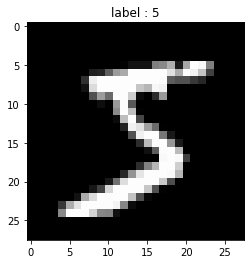

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

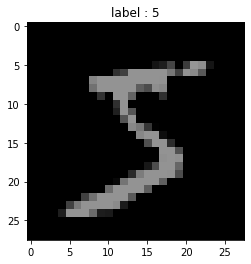

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [4]:
import numpy as np

index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray', vmin=0, vmax=255)
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())
print(X_train.min())

1.0
0.0


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(len(y_train))

(48000, 784)
(12000, 784)
48000


### **層などのクラス化**

### **【問題1】全結合層のクラス化**

In [124]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        # 初期化
        self.initializer = initializer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        pass
    
    def forward(self, X):
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A
    
    def backward(self, dA):
        self.dW = np.dot(self.X.T, dA)
        self.dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)
        # 更新
        self = self.optimizer.update(self)
        return dZ

### **【問題2】初期化方法のクラス化**

In [125]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(n_nodes2)
        return B

### **【問題3】最適化手法のクラス化**

In [391]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        layer.W -= self.lr * (layer.dW)
        layer.B -= self.lr * (layer.dB)
        return layer.W, layer.B

### **【問題4】活性化関数のクラス化**

In [378]:
class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x):
        C = np.max(x)
        y = np.exp(x / C) / np.exp(x / C).sum(axis=1).reshape(-1, 1)
        return y
    
    def backward(self, y, t):
        self.y = y
        self.t = t
        batch_size = self.y.shape[0]
        self.loss = -np.sum(t * np.log(y+1e-7)) / batch_size
        dx = (self.y - self.t) / batch_size
        return dx

In [379]:
class Tanh:
    
    def __init__(self):
        pass
    
    def forward(self, X):
        C = np.max(X)
        self.A = (np.exp(X/C) - np.exp(-X/C)) / (np.exp(X/C) + np.exp(-X/C))
        return self.A
    
    def backward(self, dZ):
        return dZ * (1 - (self.A)**2)

In [381]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.A = sigmoid(X)
        return self.A
    
    def backward(self, dZ):
        return dZ * (1 - self.A) * self.A

### **【問題5】ReLUクラスの作成**

In [382]:
class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, X):
        self.mask = X > 0
        A = X * self.mask
        return A
    
    def backward(self, dA):
        dZ = dA * self.mask
        return dZ

### **【問題6】重みの初期値**

In [383]:
class Xavier:
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [384]:
class He:
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### **【問題7】最適化手法**

In [385]:
a = np.array([1, 4, 7, 3])
np.mean(a)

3.75

In [386]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [387]:
class AdaGrad0:
    def __init__(self, lr):
        self.lr = lr
        self.h_w = None
        self.h_b = None
        
    def update(self, layer):
        h_w = np.zeros_like(layer.dW)
        h_b = np.zeros_like(layer.dB)
        # 更新式
        get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
        for mini_X_train, mini_y_train in get_mini_batch:
            n_b = mini_X_train.shape[0]
            h_w += (layer.dW/n_b) * (layer.dW/n_b)
            layer.W -= self.lr * (layer.dW/n_b) / np.sqrt(h_w + 1e-7)
            h_b += (layer.dB/n_b) * (layer.dB/n_b)
            layer.B -= self.lr * (layer.dB/n_b) / np.sqrt(h_b + 1e-7)
            return layer.W, layer.B

In [388]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_w = None
        self.h_b = None
        
    def update(self, layer):
        h_w = np.zeros_like(layer.dW)
        h_b = np.zeros_like(layer.dB)
        # 更新式
        n_b = layer.X.shape[0]
        h_w += (layer.dW/n_b) * (layer.dW/n_b)
        layer.W -= self.lr * (layer.dW/n_b) / np.sqrt(h_w + 1e-7)
        h_b += (layer.dB/n_b) * (layer.dB/n_b)
        layer.B -= self.lr * (layer.dB/n_b) / np.sqrt(h_b + 1e-7)
        return layer.W, layer.B

### **【問題8】クラスの完成**

In [230]:
class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, lr, sigma, iters_num, n_input, n_nodes1, n_nodes2, n_output):
        self.lr = lr
        self.iters_num = iters_num
        self.n_input = n_input
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        
        
    def fit(self, X, y):
        optimizer = AdaGrad(self.lr)
        self.FC1 = FC(self.n_input, self.n_nodes1, Xavier(), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier(), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(), optimizer)
        self.activation3 = Softmax()
        
        for _ in range(self.iters_num):
            A1 = self.FC1.forward(X)
            #print('A1', A1)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            #print('A2', A2)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            np.set_printoptions(edgeitems=10)
            #print('A3', A3)
            self.Z3 = self.activation3.forward(A3)
            
            dA3 = self.activation3.backward(self.Z3, y)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            self.dA1 = self.activation1.backward(dZ1)
            self.dZ0 = self.FC1.backward(self.dA1)
            

### **【問題9】学習と推定**

In [218]:
dnn = ScratchDeepNeuralNetworkClassifier(lr=0.01, sigma=0.01, iters_num=1, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn.fit(X_train, y_train)


A1 [[-4.82647517e-01 -1.80095194e-01  1.31872642e-01 -6.37280020e-02
   1.92233268e-01  8.90298418e-02  1.31048651e-01 -4.53435099e-01
   2.09461600e-01 -1.51068290e-01 ... -1.69219939e-01  7.43194494e-01
   1.04112945e-01 -3.84465742e-02  1.14192522e-01  1.90566955e-01
   1.64165942e-01  2.60566936e-01  4.11184927e-01  1.36615247e-01]
 [-1.64219095e-01 -4.77299029e-01  1.42363164e-01  8.19329161e-01
  -6.86796912e-01  8.85741956e-02  9.00271605e-01 -1.27691122e-01
   3.69318632e-01  3.66769861e-01 ...  1.05603485e-01  3.80183671e-01
   3.42255782e-01  2.58637222e-01 -1.13945348e-01  8.10550549e-01
  -3.63311981e-01  4.07912919e-01  4.17738500e-02 -2.57757054e-01]
 [-2.18955879e-01 -2.05463677e-01  3.44012165e-02 -5.74988732e-02
   2.86038814e-01 -9.69335275e-04  3.96234955e-01 -1.80973923e-01
   7.08739373e-03  1.15406571e-01 ... -4.19415858e-01  5.10017689e-01
   1.66505477e-01  6.65207907e-02  1.64390831e-01 -8.39115279e-02
  -8.32434560e-02  5.92783183e-01 -4.30389012e-02  8.862739

A3 [[ 1.70154934e-01 -1.31184610e-01 -6.59707440e-02  6.21404763e-02
   1.55123931e-02  7.61775273e-02  1.66845022e-01 -1.27001982e-01
  -2.12449132e-01  6.86356716e-02]
 [-1.31092377e-01 -2.05143816e-01  7.95278235e-02 -2.39645790e-01
   5.19164003e-02  1.57195863e-02  1.42692948e-01  1.68358164e-02
   3.27383117e-02 -6.14775573e-02]
 [ 3.66323160e-02 -1.33895277e-01  1.67685790e-04  8.40929718e-02
   1.20442165e-01  7.67202265e-02  7.85536125e-02  2.55306144e-01
  -1.63104455e-01 -5.24491352e-02]
 [ 2.09771913e-02  4.98965112e-02  1.21832704e-01  2.73193015e-02
   4.74593253e-02 -3.86847514e-02  5.42728940e-02  9.07939638e-02
  -2.84014972e-01 -8.55780737e-02]
 [ 2.52080563e-03 -5.46612761e-02  1.74595780e-01  9.08292987e-02
   1.83223716e-01 -1.28976525e-01  1.09710269e-01  1.41294634e-01
   4.48503676e-02 -2.06236858e-01]
 [-2.22136209e-01  6.15036130e-02  1.31980398e-01  3.58405599e-02
   4.04539474e-01  2.59037020e-02 -3.79319345e-02  3.95428279e-02
  -2.25974528e-01 -1.76482673e

In [219]:
y_hat = dnn.Z3
pred = np.argmax(y_hat, axis=1)
pred

array([0, 6, 7, 2, 4, 4, 9, 2, 7, 3, ..., 2, 7, 2, 3, 2, 3, 2, 2, 7, 2])

In [157]:
dnn.Z3[:10]

array([[0.16136997, 0.06052037, 0.16826497, 0.02553451, 0.28036707,
        0.03304643, 0.09643788, 0.04436116, 0.108188  , 0.02190963],
       [0.16134043, 0.06051232, 0.16829141, 0.02554049, 0.28038306,
        0.03303292, 0.09645282, 0.04437496, 0.10817037, 0.02190124],
       [0.1613548 , 0.06052268, 0.16827442, 0.025538  , 0.28035635,
        0.03304247, 0.09641882, 0.04436764, 0.10821567, 0.02190916],
       [0.16133611, 0.06051983, 0.16825865, 0.02553179, 0.28043003,
        0.03303963, 0.09642663, 0.04436572, 0.10818279, 0.02190883],
       [0.16133677, 0.06053764, 0.16826841, 0.02553094, 0.28038189,
        0.03304355, 0.096438  , 0.04436948, 0.10818984, 0.0219035 ],
       [0.1613751 , 0.0605204 , 0.16823192, 0.02553281, 0.28039462,
        0.03303854, 0.09643597, 0.0443714 , 0.10819424, 0.02190499],
       [0.16139535, 0.06051856, 0.16828553, 0.02553277, 0.28034599,
        0.03304515, 0.09641334, 0.04435571, 0.10820276, 0.02190484],
       [0.16134314, 0.06051519, 0.1682685

In [152]:
dnn.Z3.shape

(48000, 10)

In [153]:
y_train.shape

(48000, 10)

In [155]:
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [160]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [166]:
dnn.dA1[0].shape

(400,)

In [169]:
dnn.dZ0[0].shape

(784,)

In [172]:
dnn.FC1.dW[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [174]:
dnn.FC1.dW[0].shape

(400,)

In [173]:
dnn.FC2.dW[0]

array([ 4.24932425e-04,  7.75590480e-04,  5.02740261e-04,  2.01669858e-04,
        1.36525891e-03, -4.53443365e-04, -1.32740939e-03, -3.80727555e-04,
       -7.91010067e-04,  1.00459920e-03,  1.12443994e-04,  1.39588314e-03,
       -9.20063169e-04, -3.32562513e-04,  8.38650129e-04, -1.13387049e-04,
       -4.24736429e-04, -1.97897565e-04,  5.79492681e-04, -5.92989012e-04,
        1.26406964e-03, -6.48232479e-04,  1.34909591e-04, -2.24180241e-04,
       -9.47767194e-04,  2.25149901e-04,  6.73113263e-04, -1.22614650e-04,
       -1.61700779e-03, -3.41418096e-04,  7.13342677e-05,  8.92728717e-04,
       -7.40385642e-05,  7.14835038e-04, -1.54019526e-04, -1.40045241e-05,
        7.91797080e-05,  8.77421075e-04, -1.14832830e-05, -2.41820633e-04,
       -6.71704413e-04,  7.24113570e-04, -5.94863508e-04,  1.29497910e-04,
       -1.47352668e-03,  1.01442797e-03,  9.51223738e-04, -2.47488493e-04,
        5.93009548e-04,  2.56963870e-04, -8.09767704e-04, -5.89869843e-04,
        1.63384405e-04, -

In [175]:
dnn.FC2.dW[0].shape

(200,)

In [176]:
dnn.FC3.dW[0]

array([-0.02017287,  0.01669273, -0.02179785,  0.02434411, -0.0585139 ,
        0.01808198,  0.00090122,  0.01915585, -0.00315452,  0.02446325])

In [177]:
dnn.FC3.dW[1]

array([ 0.02440475, -0.02018967,  0.02635912, -0.02945647,  0.07061322,
       -0.02186059, -0.001104  , -0.0229863 ,  0.00374036, -0.02952041])

In [221]:
np.argmax(y_train, axis=1)

array([5, 0, 3, 1, 6, 3, 5, 1, 6, 6, ..., 6, 4, 1, 1, 5, 6, 2, 0, 9, 6])

In [222]:
print((np.sum(pred == y_train)) / len(y_train))
print()

0.0


/Users/kobayashishintachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [223]:
np.sum(pred == y_train)

/Users/kobayashishintachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


0

In [224]:
dnn2 = ScratchDeepNeuralNetworkClassifier(lr=0.01, sigma=0.01, iters_num=20, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn2.fit(X_train, y_train)

A1 [[-1.78824756e-03  3.63778889e-01  4.43428502e-01 -7.12153885e-01
  -6.69258574e-02  4.40877282e-01  8.30766914e-01 -3.64043614e-01
   2.32591208e-01  8.21489890e-02 ... -3.69225889e-01 -2.02308263e-01
   1.72890850e-02 -9.33215283e-02  2.27380307e-01  4.69330945e-01
   1.64781629e-01  1.88723604e-01 -5.11909041e-01 -1.06800540e+00]
 [ 7.75424856e-01 -1.12469705e-01  1.06918851e-01 -4.67595265e-01
  -1.10926150e+00  1.15997411e-01  4.16937519e-01 -2.60862101e-01
   1.97623020e-01  5.41231483e-01 ... -2.47269288e-01 -1.20518832e-01
  -2.61356388e-01 -2.44843557e-01  7.50941011e-01  3.50570469e-01
  -3.50368680e-01 -1.09128516e-01  2.79062777e-01 -1.70804655e-01]
 [-5.64012388e-02  4.16065249e-01  1.74207681e-01 -2.62966443e-01
  -1.16297481e-01  1.90803399e-01  8.54689023e-02 -7.06416273e-02
   1.62500150e-01  2.78152154e-01 ... -2.06155710e-01  9.29129541e-02
   1.42993365e-01 -4.38063471e-01  2.16907475e-02  7.10401802e-01
   2.63769489e-01  2.11199488e-01 -4.35287287e-01 -5.205706

A3 [[ 0.17871929 -0.03713212  0.03390526 -0.12109816 -0.00509506  0.00685433
  -0.03245348 -0.16268924 -0.0246765  -0.08993809]
 [ 0.02226825 -0.1042347   0.13487166  0.04654701  0.11783593 -0.25353504
   0.05341644  0.04992167 -0.1160483  -0.33611964]
 [ 0.0879502  -0.04490317  0.03470761 -0.0714703  -0.05977053 -0.14167761
  -0.21287419 -0.08264205  0.13153371 -0.13632034]
 [ 0.03454673 -0.03932127  0.00272036 -0.23301628  0.16246112 -0.16796818
  -0.10633501 -0.08167953 -0.06757899 -0.14387313]
 [-0.03596486  0.13307905 -0.00748953 -0.29500966  0.02052691 -0.11694774
  -0.0840733  -0.10968452 -0.04336997 -0.33854352]
 [ 0.20298733 -0.00471921 -0.09779777 -0.17544271  0.07945863 -0.18053899
  -0.0077957  -0.00963484  0.01826428 -0.24173331]
 [ 0.30447581 -0.03464012  0.13687192 -0.17734549 -0.04440105 -0.03899557
  -0.20228539 -0.20708463  0.09735761 -0.23323874]
 [ 0.09870641 -0.07612727  0.08193206 -0.14401986  0.10592039 -0.16384752
  -0.05750024 -0.08262451  0.05678173 -0.1413325

A2 [[ 2.14707432e-01  2.88824793e-01  1.01722339e-01 -3.17105302e-04
   1.67023857e-01 -1.11248449e-01 -1.91830330e-01  2.34398650e-01
   1.30308532e-01  3.93162795e-01 ... -2.44063740e-01  1.71452298e-01
   1.37290030e-01  5.76756588e-01  4.35479688e-01 -1.22297881e-01
   1.82246638e-01  3.96898870e-01  1.84186946e-01 -8.66381436e-02]
 [-1.42254904e-02  1.36251594e-01 -3.86592695e-02 -1.26676125e-01
  -5.97715688e-03 -2.43494853e-01 -1.54477231e-01  1.18684259e-01
  -7.54006262e-02  5.58873537e-01 ... -3.06239559e-02  3.00287735e-01
  -9.92034523e-02  8.49836659e-02  3.17453244e-01 -1.13441492e-01
  -7.00854875e-03  3.40577827e-01  1.80709144e-01 -2.19282733e-01]
 [ 1.03926607e-01  1.90537808e-01 -3.71624254e-03 -7.50579438e-02
   1.24369493e-01 -1.00419403e-01 -1.11356667e-01  9.45244978e-02
   9.54008432e-02  3.71079572e-01 ... -9.54501314e-02  1.28411524e-01
   5.98156309e-02  3.85766969e-01  3.05191016e-01 -2.06171757e-01
   7.57538031e-02  2.30327033e-01  1.42341246e-01 -1.188997

A1 [[-3.49633499e-01  4.76979415e-01  7.70052028e-01 -5.62750271e-01
  -3.73821484e-01  6.17236012e-01  9.52695672e-01 -2.49867187e-01
   6.27459550e-01 -3.38626149e-01 ...  2.41003211e-01  1.13123012e-02
  -6.25224600e-02  9.41997079e-02  6.86921136e-01  7.98315282e-01
  -1.19110654e-01 -1.76691968e-01 -2.73073724e-01 -7.82181550e-01]
 [ 1.02973005e+00 -2.68765343e-01 -1.87203457e-02 -3.67084205e-01
  -8.67593512e-01  4.47663175e-01  3.11763234e-01 -2.50997228e-01
   3.09027723e-01  1.81617021e-01 ... -2.21414551e-01  1.35546711e-01
  -2.68454497e-01 -2.11558518e-01  4.02167824e-01  3.42109843e-01
  -6.16112226e-01 -1.96735554e-01  1.98346492e-01 -6.54219770e-02]
 [-2.78146092e-01  4.21967743e-01  3.04500045e-01 -2.24369909e-01
  -3.41252213e-01  2.08485761e-01  1.91644590e-01  1.18420857e-01
   2.15441613e-01  1.86078670e-01 ... -1.50539572e-02  2.86116667e-02
   7.41084065e-02 -3.01651807e-01  1.80805644e-01  8.78039333e-01
   1.84254846e-01  1.67927542e-01 -3.64580550e-01 -4.384903

A3 [[ 0.5684293  -0.83120217 -0.19139447  0.9641103  -0.2819927   0.42135555
  -0.11413167 -0.68251723  0.43554252 -0.26032144]
 [ 1.83793216 -1.04123566  0.24302301 -0.79275854 -0.50399509 -0.50671043
   0.83008396  0.42001689 -0.57210457 -0.67274319]
 [ 0.15260032 -0.03292547 -0.06425299  0.53469195 -0.46011428  0.13799009
   0.04530253 -0.24206084  0.08178246 -0.30469783]
 [-0.89915115  1.39073103  0.27129097 -0.27038959 -0.26093618 -0.2958805
  -0.14192204 -0.26031505  0.52213661 -0.26618665]
 [ 0.60845359 -0.59085979  0.05304959 -0.91281732  0.15681241 -0.53642067
   0.67235949  0.12582439 -0.43148174 -0.09174132]
 [-0.54642655 -0.30532016 -0.0541141   0.34867853  0.67271793 -0.53233733
  -0.58185294 -0.24519507  0.35310718  0.45097035]
 [ 0.21649138 -0.34621622 -0.24474594  0.52424544 -0.35810841  0.35621286
  -0.32800097 -0.46593257  0.93335511 -0.19300882]
 [-0.50366542  1.00226855  0.12962172 -0.26109212 -0.24127355 -0.15424273
   0.00201478 -0.05766645  0.29047425 -0.24985941

A3 [[ 0.91660691 -0.86623497 -0.17855255  1.54462813 -0.73967006  0.78629482
  -0.38068236 -0.87269108  0.56166342 -0.47012746]
 [ 2.45362951 -1.32364918  0.31780098 -0.48795018 -0.9807951  -0.19498494
   0.82361533  0.24604845 -0.65684675 -0.86490788]
 [ 0.32994786  0.02477308 -0.01984343  0.85871203 -0.75259196  0.35959256
  -0.07026733 -0.37217828  0.14308953 -0.4558911 ]
 [-1.09174843  1.7875448   0.38879397 -0.04313223 -0.55810628 -0.21673061
  -0.32387843 -0.32955596  0.74164543 -0.3651557 ]
 [ 0.83533072 -0.79461806  0.08609205 -0.83016911  0.06412804 -0.46549967
   0.74749888  0.13031684 -0.52221456 -0.07885657]
 [-0.63073233 -0.22312408 -0.09983251  0.67249264  0.4991387  -0.35606288
  -0.88830359 -0.21040699  0.47867049  0.55051547]
 [ 0.46893351 -0.23968766 -0.27857492  1.20537712 -0.91825306  0.7691463
  -0.70551675 -0.59745246  1.11383298 -0.35374372]
 [-0.64888406  1.28617419  0.18122482 -0.13393657 -0.43935801 -0.09982385
  -0.1240511  -0.08607642  0.41146709 -0.31284144

A2 [[ 4.61573769e-01  3.15214119e-01  1.88864171e-01  3.57158087e-01
   1.60987544e-01  3.00838299e-01 -3.90681502e-01 -2.42705448e-01
   4.85812031e-01  4.91112499e-01 ... -4.94250449e-01  5.75086865e-02
   3.22459561e-01  9.03293957e-01  4.92397111e-01 -8.31652280e-03
   3.72764507e-01  6.14231742e-01 -5.00194615e-02 -3.01922349e-01]
 [ 1.06646818e-01  4.83809443e-01 -2.77245393e-01  7.66656934e-02
  -6.08221978e-01 -1.44686303e-01  5.42271713e-02 -3.14406987e-01
   4.79179719e-01  6.90763945e-01 ...  3.05771081e-01  3.13647251e-01
  -6.53264024e-01  3.02431002e-01  3.14487351e-01  7.97077587e-01
   4.26968744e-01  6.31652954e-01 -5.36232058e-02 -3.84285505e-01]
 [ 1.22471351e-01  2.39501544e-01  1.72209022e-01  1.63518314e-01
   1.80972501e-01  1.14853782e-01 -2.65982605e-01 -6.36691853e-02
   1.91717737e-01  3.28881746e-01 ... -3.01544077e-01  1.48540748e-01
   1.29200936e-01  4.33380549e-01  2.73915932e-01 -1.86653524e-01
   2.00622610e-01  2.73731013e-01 -3.99854924e-02 -2.961281

A1 [[-1.19246387e+00  6.80327515e-01  1.41615265e+00 -2.99169552e-01
  -9.61277153e-01  1.41497155e+00  1.26256951e+00 -6.56927895e-01
   1.54589147e+00 -1.23356320e+00 ...  1.38436213e+00  4.30500868e-01
  -9.91466707e-02  7.95122806e-01  1.65848051e+00  1.43843441e+00
  -6.41799835e-01 -9.21219078e-01 -4.68840253e-01 -7.58821005e-01]
 [ 1.69568400e+00 -7.16899395e-01  3.92369720e-02 -5.57681712e-01
  -5.61685068e-01  1.39344288e+00  4.67522833e-01 -9.23747812e-01
   9.40495047e-01 -4.42866031e-01 ...  2.12030850e-01  7.67038366e-01
  -4.63841961e-01 -3.52653744e-02  2.90827275e-01  5.71792124e-01
  -1.01240327e+00 -4.98909566e-01  7.32861203e-02  1.80509114e-01]
 [-7.80516649e-01  3.61596459e-01  5.14012946e-01 -1.15381910e-01
  -7.73438134e-01  3.93409882e-01  2.66522661e-01  5.93526006e-02
   4.47509416e-01 -6.89918476e-02 ...  3.64462718e-01  9.67383091e-02
   1.55679546e-02  1.02959161e-01  6.63554184e-01  1.25764815e+00
   2.01397721e-02 -4.59836197e-02 -6.91689440e-01 -5.512122

A3 [[ 1.40737539 -0.89747164 -0.0440014   1.8790478  -1.0618269   1.0354856
  -0.49017874 -1.14095202  0.60335026 -0.867226  ]
 [ 3.02632155 -1.90347945  0.39589397 -0.48499583 -0.85963211  0.00728488
   1.1887654  -0.10543211 -1.02406919 -1.04412882]
 [ 0.59503484  0.06761047  0.15142886  1.03136107 -0.95676417  0.49627027
  -0.1090847  -0.62158877  0.23595956 -0.75084349]
 [-1.48924391  2.28026569  0.5631103   0.1334358  -0.72114082 -0.25971931
  -0.51678439 -0.38419923  1.00006696 -0.48919802]
 [ 0.9715841  -1.150765    0.06945962 -1.04583128  0.41356234 -0.49895776
   1.02821569  0.16579099 -0.83293936  0.01104958]
 [-0.92357146 -0.02063512 -0.33124128  0.56949724  0.65415255 -0.2934704
  -1.09689318  0.13363245  0.49322736  0.73593095]
 [ 0.65351075 -0.11557369 -0.27278773  1.56199793 -1.08039833  0.93691289
  -0.95506702 -0.68597549  1.10437192 -0.56636442]
 [-0.94933227  1.60876597  0.27743491 -0.0333773  -0.52485872 -0.15377107
  -0.28074201 -0.10952864  0.57324563 -0.3671302 ]

A3 [[ 1.67645481 -0.88308258  0.06825756  2.05237618 -1.30101512  1.17065099
  -0.51708328 -1.2996719   0.63048155 -1.11640608]
 [ 3.30013696 -2.18934827  0.44055755 -0.42424547 -0.82876149  0.12966062
   1.36523506 -0.31026543 -1.17610902 -1.14490425]
 [ 0.75234664  0.09109754  0.26819696  1.1370095  -1.10766238  0.56808138
  -0.11850737 -0.77571698  0.29675175 -0.9337803 ]
 [-1.63112509  2.48187078  0.64127655  0.25459968 -0.82438616 -0.26881923
  -0.61528996 -0.41978959  1.12118653 -0.56128523]
 [ 1.04157502 -1.32378591  0.04689742 -1.13539083  0.55646344 -0.50321977
   1.15062201  0.17537028 -0.97381909  0.05453383]
 [-1.0238264   0.09341459 -0.45840958  0.52217417  0.66558931 -0.26076548
  -1.19714474  0.31568475  0.50539656  0.79944496]
 [ 0.78108754 -0.04174927 -0.23445914  1.75266737 -1.23890803  1.03286343
  -1.06953159 -0.74516952  1.11091277 -0.71493927]
 [-1.06048321  1.73430953  0.32427452  0.04366507 -0.57630468 -0.17558423
  -0.36161812 -0.1276082   0.65397676 -0.3966104

A3 [[ 1.94955091 -0.86542332  0.20663745  2.23231355 -1.56321409  1.31023371
  -0.51970314 -1.48279104  0.66305196 -1.38754264]
 [ 3.57005856 -2.47437702  0.49302005 -0.36198905 -0.80580509  0.24911394
   1.55073595 -0.51806284 -1.31891542 -1.24952252]
 [ 0.91793429  0.11329719  0.40201503  1.2571063  -1.27819264  0.64463812
  -0.11243098 -0.94819269  0.35903017 -1.133355  ]
 [-1.75094365  2.67088103  0.71558239  0.38400676 -0.9324157  -0.27328653
  -0.7111575  -0.46179309  1.24075347 -0.63510301]
 [ 1.11193062 -1.49767072  0.0193534  -1.22747711  0.69100792 -0.51073423
   1.27336262  0.1851606  -1.11114695  0.10166875]
 [-1.11471576  0.20612843 -0.58403329  0.47668574  0.66780218 -0.23866751
  -1.29645882  0.49004601  0.51996692  0.86086567]
 [ 0.91252142  0.03098638 -0.17849165  1.93874735 -1.41475144  1.13051508
  -1.16603567 -0.81984504  1.13022297 -0.87620372]
 [-1.15706327  1.85152804  0.36823947  0.12670378 -0.62943636 -0.19388512
  -0.44011845 -0.14863317  0.73452565 -0.4260548

A2 [[ 8.78294481e-01  6.60421324e-01  7.87542029e-01  1.12366562e+00
   1.62093013e-01  1.24930223e+00 -1.09984865e+00 -1.59392155e+00
   1.44909713e+00  1.15266605e+00 ... -1.42207428e+00  1.18089986e-01
   7.66572556e-01  1.76945945e+00  1.14411553e+00  1.29727947e-02
   1.03402977e+00  1.72915162e+00 -8.13242979e-01 -1.24534290e+00]
 [ 7.72594616e-01  1.84274084e+00 -7.95882603e-01  7.26604314e-01
  -1.81124933e+00 -2.37936999e-02  3.38513160e-01 -8.95185207e-01
   1.56213651e+00  1.51903865e+00 ...  5.66776117e-01  6.39874882e-01
  -1.32446795e+00  1.14535403e+00  6.67402606e-01  2.41235428e+00
   1.49949844e+00  1.33377919e+00 -3.95162474e-01 -5.69627406e-01]
 [ 5.81906016e-02  2.82971659e-01  7.62199172e-01  7.30501686e-01
   2.40953745e-01  7.79725952e-01 -7.44285283e-01 -7.55505824e-01
   6.73081407e-01  4.99443219e-01 ... -1.02453964e+00  3.24281844e-01
   4.99030588e-01  6.45940737e-01  5.01717381e-01 -3.23387416e-01
   6.81085889e-01  8.60978063e-01 -4.15420710e-01 -8.538672

A1 [[-2.62130099  0.54358652  2.7290084   0.34002214 -2.15266556  3.02498431
   1.77998043 -1.67559282  2.93389093 -3.02470264 ...  2.98255036
   1.44523516 -0.37542581  1.86532672  3.12235517  2.5412013  -1.53716205
  -2.24762322 -1.39793811 -1.50632226]
 [ 2.85463806 -1.72680457  0.77769659 -1.48830714 -0.10851378  3.44093539
   1.53147612 -1.9253906   2.22390754 -2.12616482 ...  1.20304034
   1.62562993 -0.88339621 -0.22677643  0.25217003  1.08017729 -1.8603921
  -1.12847424 -0.16690063  0.37954874]
 [-1.69841193 -0.1743705   0.81545989  0.13383426 -1.63301704  0.75848357
   0.21158975 -0.48694759  0.89995283 -0.51720007 ...  0.93359893
   0.72468608 -0.36612704  0.53780717  1.56768493  2.00010136 -0.41679907
  -0.61295279 -1.60875678 -1.29018644]
 [-0.85553913 -1.45008495 -1.50824259  0.13231438 -1.10412289 -2.94765425
  -2.42066866  0.55606429 -2.54592648  2.37958258 ... -2.07874133
   0.85432126 -1.4985653  -0.39618744  0.63257409  0.14388147  0.67460832
   0.09769256 -2.69619217

A3 [[ 2.49189788 -0.81946755  0.5502816   2.62297772 -2.13307794  1.60423227
  -0.47214799 -1.91698384  0.75248341 -1.97899782]
 [ 4.09490741 -3.0313032   0.62148272 -0.2600747  -0.77752603  0.46827539
   1.94618838 -0.92025019 -1.58653729 -1.46501734]
 [ 1.2622136   0.15949211  0.71212095  1.53978874 -1.66372794  0.81657416
  -0.06188934 -1.33830999  0.48699658 -1.57199904]
 [-1.95804809  3.04268591  0.85592695  0.65610439 -1.15994067 -0.2691818
  -0.90389672 -0.55603448  1.48391433 -0.78527175]
 [ 1.24396631 -1.84431996 -0.0473454  -1.42933006  0.95090894 -0.54274198
   1.52091623  0.21772418 -1.37995906  0.21062711]
 [-1.30888614  0.43466707 -0.8294449   0.38618807  0.6780291  -0.22792003
  -1.50454241  0.82167867  0.5597102   0.99821222]
 [ 1.1523991   0.19157886 -0.02733924  2.29876718 -1.79076932  1.32710135
  -1.32314212 -1.00477663  1.21318026 -1.21628494]
 [-1.33127063  2.08528145  0.44652439  0.29916277 -0.74044562 -0.22021351
  -0.59567112 -0.19173087  0.89838895 -0.48406894

A3 [[ 2.76063565 -0.79175864  0.75335836  2.83371639 -2.43427988  1.756962
  -0.42593953 -2.16591571  0.80909541 -2.29541145]
 [ 4.35009595 -3.30012163  0.69889327 -0.22084968 -0.77261401  0.56725223
   2.15438372 -1.11487486 -1.71300251 -1.57702401]
 [ 1.43955424  0.18368789  0.88586443  1.69896426 -1.87316873  0.91132964
  -0.02021841 -1.55265063  0.55263611 -1.80754421]
 [-2.04908586  3.22771796  0.92357202  0.79645017 -1.27900431 -0.2606296
  -1.00134373 -0.6068356   1.60773209 -0.86230618]
 [ 1.30440878 -2.01495298 -0.08441217 -1.53726258  1.07770795 -0.56666286
   1.64414088  0.24062905 -1.51139853  0.27034194]
 [-1.41566057  0.55045392 -0.94695193  0.34007578  0.68976123 -0.23724721
  -1.61203806  0.97869237  0.58458738  1.07379601]
 [ 1.26105996  0.27989946  0.0680827   2.47455219 -1.98643415  1.42413798
  -1.38486658 -1.11558619  1.27351413 -1.39432322]
 [-1.41152534  2.20344491  0.48171383  0.38624484 -0.79851818 -0.22856949
  -0.67308697 -0.21297722  0.98140295 -0.51348865]


A3 [[ 3.02380022e+00 -7.60447165e-01  9.73759222e-01  3.04941524e+00
  -2.73928270e+00  1.90957251e+00 -3.66150374e-01 -2.43012736e+00
   8.71266643e-01 -2.61954453e+00]
 [ 4.59509885e+00 -3.55773717e+00  7.83717169e-01 -1.88207412e-01
  -7.72538334e-01  6.58315030e-01  2.36549032e+00 -1.30374574e+00
  -1.83376384e+00 -1.68982878e+00]
 [ 1.61687835e+00  2.08559494e-01  1.06839282e+00  1.86443041e+00
  -2.08728751e+00  1.00912423e+00  3.04845880e-02 -1.77445971e+00
   6.18325450e-01 -2.04837034e+00]
 [-2.13010116e+00  3.40772554e+00  9.88755439e-01  9.37085276e-01
  -1.39904533e+00 -2.47913965e-01 -1.09792976e+00 -6.58451112e-01
   1.73017647e+00 -9.39612084e-01]
 [ 1.35851396e+00 -2.17923372e+00 -1.23107652e-01 -1.64597104e+00
   1.20078268e+00 -5.94434169e-01  1.76324653e+00  2.67488245e-01
  -1.63853084e+00  3.31807743e-01]
 [-1.52699839e+00  6.66171138e-01 -1.05904830e+00  2.92304432e-01
   7.05701925e-01 -2.54929848e-01 -1.71829961e+00  1.12885665e+00
   6.11062821e-01  1.15143477e

A2 [[ 1.08721902e+00  1.05156790e+00  1.86442236e+00  2.35848386e+00
   3.15656540e-02  2.65777656e+00 -2.26420811e+00 -3.36434672e+00
   2.78363013e+00  2.03535171e+00 ... -2.75588578e+00  6.33490220e-01
   1.46945825e+00  2.70009301e+00  2.05158778e+00 -4.97773354e-02
   2.14310502e+00  3.35738196e+00 -2.04812375e+00 -2.72239223e+00]
 [ 1.63782110e+00  3.80260531e+00 -1.46900705e+00  1.75882729e+00
  -3.49798041e+00 -3.08408488e-02  7.59081797e-01 -1.51226491e+00
   3.03302021e+00  2.53399439e+00 ...  7.42776430e-01  1.22550171e+00
  -2.13051640e+00  2.15053273e+00  1.03232633e+00  4.41935400e+00
   2.91461082e+00  1.94288288e+00 -8.58859476e-01 -6.10017383e-01]
 [-2.07946256e-01  3.24182536e-01  1.68405395e+00  1.64685448e+00
   1.42094884e-01  1.81920655e+00 -1.52403117e+00 -1.81206634e+00
   1.50502463e+00  7.35103521e-01 ... -2.09073367e+00  8.33325483e-01
   1.16348224e+00  8.49725676e-01  8.23727693e-01 -5.27331639e-01
   1.52647490e+00  1.79974700e+00 -1.03573469e+00 -1.711592

A1 [[-4.21071082e+00 -2.85679094e-01  4.45044277e+00  1.13651796e+00
  -3.63556978e+00  4.76294464e+00  1.76517134e+00 -2.93135651e+00
   4.12436126e+00 -5.08078934e+00 ...  4.39678914e+00  2.71441886e+00
  -8.91451633e-01  3.08761559e+00  4.67531217e+00  3.76986228e+00
  -2.41429386e+00 -3.65138047e+00 -2.63699580e+00 -2.71007300e+00]
 [ 3.61045361e+00 -2.73888472e+00  2.65179796e+00 -3.10417387e+00
  -1.26020015e-01  5.82474663e+00  3.00305903e+00 -2.79108624e+00
   3.51182019e+00 -4.33144346e+00 ...  2.25857401e+00  2.41012669e+00
  -1.26519151e+00 -5.21622144e-01  5.28751458e-01  1.77140280e+00
  -2.66653834e+00 -1.80339097e+00 -4.22971281e-01  3.07461451e-01]
 [-2.79137423e+00 -1.18013369e+00  1.09434431e+00  3.17542514e-01
  -2.67362782e+00  1.15230275e+00 -2.45100941e-01 -1.29250639e+00
   1.46151771e+00 -1.03142208e+00 ...  1.59914458e+00  1.60801833e+00
  -9.76513727e-01  9.12440433e-01  2.60131101e+00  2.84099822e+00
  -9.84551488e-01 -1.36669076e+00 -2.67555432e+00 -2.313334

A3 [[ 3.55640731 -0.69928127  1.46480423  3.5088995  -3.36883431  2.22437008
  -0.20932979 -3.01162529  1.01190863 -3.29869954]
 [ 5.08168801 -4.05850024  0.97855309 -0.13310313 -0.79386938  0.82543908
   2.8035815  -1.67672691 -2.06681563 -1.92867462]
 [ 1.98538951  0.25589027  1.46153314  2.22158405 -2.53695571  1.21988291
   0.15637943 -2.24787519  0.75331551 -2.55340987]
 [-2.27022298  3.76267789  1.11748093  1.22160144 -1.64622411 -0.21034345
  -1.29093321 -0.76803928  1.9769633  -1.09922015]
 [ 1.46108659 -2.50326524 -0.20309703 -1.86715345  1.43859889 -0.65911183
   1.99765442  0.32943041 -1.88818915  0.45653664]
 [-1.76342475  0.89366194 -1.27251635  0.19477025  0.75307764 -0.3101296
  -1.93195974  1.41375373  0.66904783  1.31565135]
 [ 1.56003674  0.55761067  0.42501688  2.9831519  -2.58031449  1.70133728
  -1.5000657  -1.51131086  1.49632975 -1.95076127]
 [-1.62173415  2.5502814   0.57351527  0.64168051 -0.9773994  -0.23702054
  -0.89990218 -0.27359844  1.22609056 -0.60346896

A2 [[ 1.05842284e+00  1.24357397e+00  2.54407746e+00  3.09867833e+00
  -1.08678589e-01  3.48113090e+00 -2.96941832e+00 -4.31936794e+00
   3.53547992e+00  2.48108932e+00 ... -3.53364029e+00  1.09145623e+00
   1.93838036e+00  3.12478657e+00  2.54263269e+00 -1.07214299e-01
   2.82211716e+00  4.27366528e+00 -2.78282682e+00 -3.57352612e+00]
 [ 2.06282032e+00  4.89146796e+00 -1.79337333e+00  2.35509523e+00
  -4.44438996e+00 -6.66890374e-02  1.00410830e+00 -1.80721237e+00
   3.83391464e+00  3.03640391e+00 ...  7.92310999e-01  1.61640086e+00
  -2.53738365e+00  2.64443920e+00  1.20317421e+00  5.47320661e+00
   3.68942390e+00  2.21189635e+00 -1.10379664e+00 -5.83702339e-01]
 [-4.23152332e-01  3.56481715e-01  2.23738979e+00  2.19800355e+00
   2.53212313e-02  2.43038935e+00 -2.00657834e+00 -2.41890342e+00
   2.01392782e+00  8.52515878e-01 ... -2.70980395e+00  1.22585570e+00
   1.59310629e+00  9.35331653e-01  1.00046348e+00 -6.36789093e-01
   2.04665302e+00  2.35267434e+00 -1.42776494e+00 -2.219748

A1 [[-5.01625222e+00 -8.54959835e-01  5.38291741e+00  1.51975988e+00
  -4.39759686e+00  5.61494001e+00  1.51543307e+00 -3.58387509e+00
   4.65661758e+00 -6.04186059e+00 ...  5.02866499e+00  3.36685728e+00
  -1.26517559e+00  3.68938366e+00  5.45373423e+00  4.39690617e+00
  -2.86782233e+00 -4.33741109e+00 -3.30895424e+00 -3.38768315e+00]
 [ 3.82337567e+00 -3.17114019e+00  3.84947710e+00 -4.09341561e+00
  -2.53133387e-01  7.06280300e+00  3.75260579e+00 -3.17718550e+00
   4.12766779e+00 -5.45589568e+00 ...  2.76424691e+00  2.79032167e+00
  -1.47299842e+00 -6.74634717e-01  7.27031677e-01  2.13775093e+00
  -3.05933063e+00 -2.13962551e+00 -5.65182503e-01  1.99352312e-01]
 [-3.36213562e+00 -1.72742982e+00  1.21339257e+00  3.56259896e-01
  -3.20760476e+00  1.34531090e+00 -6.28255303e-01 -1.72867585e+00
   1.76857710e+00 -1.31114833e+00 ...  1.95376049e+00  2.06972213e+00
  -1.33796166e+00  1.05942352e+00  3.12974860e+00  3.27358586e+00
  -1.30356665e+00 -1.76491350e+00 -3.22553498e+00 -2.857688

A3 [[ 4.09948582e+00 -6.37562075e-01  2.01399156e+00  4.00559468e+00
  -4.02273182e+00  2.55360830e+00 -1.02294047e-02 -3.65532590e+00
   1.17275512e+00 -4.01528110e+00]
 [ 5.56343890e+00 -4.54125743e+00  1.20173378e+00 -8.40180169e-02
  -8.40669095e-01  9.77479966e-01  3.25881822e+00 -2.04591903e+00
  -2.29124777e+00 -2.18338680e+00]
 [ 2.37346524e+00  3.01772026e-01  1.88862104e+00  2.61113279e+00
  -3.01317572e+00  1.45062382e+00  3.09626751e-01 -2.75789627e+00
   8.95321040e-01 -3.08803804e+00]
 [-2.39026163e+00  4.11579151e+00  1.24491873e+00  1.50870455e+00
  -1.90024999e+00 -1.59276448e-01 -1.48570874e+00 -8.83762883e-01
   2.22735477e+00 -1.26431873e+00]
 [ 1.55369651e+00 -2.82079159e+00 -2.87145519e-01 -2.09170842e+00
   1.66882204e+00 -7.34028553e-01  2.22560573e+00  4.02540779e-01
  -2.13345217e+00  5.84261906e-01]
 [-2.02277890e+00  1.12015924e+00 -1.47900029e+00  9.08366770e-02
   8.23324516e-01 -3.88526258e-01 -2.14944273e+00  1.68898951e+00
   7.31498111e-01  1.49476628e

A2 [[ 0.93717103  1.44304572  3.31935173  3.92325975 -0.30541059  4.38691699
  -3.75702747 -5.33334989  4.35414358  2.92821127 ... -4.39823557
   1.67421922  2.50259405  3.53401843  3.05809036 -0.17519054  3.58686231
   5.25933172 -3.59677123 -4.49555288]
 [ 2.47705668  6.04722102 -2.1039913   2.9979862  -5.46685514 -0.11175292
   1.26548634 -2.1043427   4.67947033  3.54494189 ...  0.82173317
   2.07178468 -2.94439841  3.13636297  1.36894121  6.57436024  4.51504449
   2.47510993 -1.35703209 -0.53735346]
 [-0.69694266  0.40316106  2.8562739   2.8136557  -0.13596261  3.10378276
  -2.55398294 -3.08319497  2.58504667  0.97213026 ... -3.39253341
   1.70601476  2.09173585  1.01563215  1.1908755  -0.75004562  2.63242815
   2.96492149 -1.88247825 -2.78611394]
 [-3.91196505 -4.69639129  4.06006817  0.05708838  3.40731474  2.5777444
  -2.58102909 -0.17360118 -1.6882074  -3.00425202 ... -3.16036966
   0.59376724  3.48079606 -3.46774024 -1.27077486 -5.5276277  -0.83757154
   0.0894471   0.47359852

A2 [[ 8.39534886e-01  1.54672916e+00  3.74046196e+00  4.36473863e+00
  -4.26079024e-01  4.86817561e+00 -4.17910627e+00 -5.86118689e+00
   4.78671959e+00  3.15058820e+00 ... -4.86150107e+00  2.00901164e+00
   2.82062973e+00  3.73146479e+00  3.32288053e+00 -2.12013848e-01
   3.99901457e+00  5.77517617e+00 -4.03165998e+00 -4.97979763e+00]
 [ 2.67775756e+00  6.64513061e+00 -2.25206210e+00  3.33407840e+00
  -6.00272946e+00 -1.35784697e-01  1.39940431e+00 -2.25341966e+00
   5.11532242e+00  3.80080504e+00 ...  8.29116491e-01  2.32097313e+00
  -3.14422060e+00  3.38039436e+00  1.44905612e+00  7.13872527e+00
   4.94349981e+00  2.60432898e+00 -1.48565499e+00 -5.07814618e-01]
 [-8.56534028e-01  4.33156834e-01  3.18842081e+00  3.14402203e+00
  -2.33402341e-01  3.46174743e+00 -2.85037773e+00 -3.43549889e+00
   2.89193410e+00  1.03268674e+00 ... -3.75609017e+00  1.97632828e+00
   2.36606997e+00  1.05362997e+00  1.29105385e+00 -8.07094339e-01
   2.94787270e+00  3.29177065e+00 -2.13332130e+00 -3.089775

A1 [[-6.21123111 -1.81608628  6.76363806  2.03473701 -5.54206262  6.81400451
   0.87826733 -4.574566    5.42123657 -7.32769213 ...  5.89392804
   4.34881446 -1.94896652  4.54546444  6.61381268  5.35156495 -3.576414
  -5.34544722 -4.34336927 -4.41569935]
 [ 3.99772255 -3.72503828  5.77848485 -5.70606423 -0.50441195  8.89419132
   4.82519186 -3.74084332  4.99652676 -7.07205489 ...  3.45574237
   3.34662372 -1.8347152  -0.90778614  1.05853593  2.69477984 -3.65466187
  -2.62799245 -0.80274288 -0.0133284 ]
 [-4.22651718 -2.54641608  1.37814466  0.34332304 -4.0106627   1.62370882
  -1.3520187  -2.39823163  2.25358131 -1.75429484 ...  2.48201607
   2.77068949 -1.9406929   1.21157524  3.9284199   3.93507378 -1.80930661
  -2.36651712 -4.06218007 -3.66917993]
 [-2.77015165 -3.60172314 -5.48193381  1.63591203 -2.44302832 -6.35648091
  -7.0984735   0.61880347 -4.90794702  5.05087961 ... -3.82436234
   1.63596824 -3.22560417 -0.58669282  1.5790263   0.51250105  2.02186554
   0.439375   -5.44118624 

A3 [[ 4.94356709e+00 -5.42206416e-01  2.93038164e+00  4.81711792e+00
  -5.04963452e+00  3.07816447e+00  3.57087361e-01 -4.71997814e+00
   1.44583008e+00 -5.15552811e+00]
 [ 6.27790681e+00 -5.23390145e+00  1.57869187e+00 -3.95196389e-03
  -9.55309952e-01  1.19022065e+00  3.96394604e+00 -2.59937884e+00
  -2.61317388e+00 -2.59365360e+00]
 [ 2.99491300e+00  3.68725680e-01  2.58492586e+00  3.24942372e+00
  -3.77284848e+00  1.83283267e+00  5.83118774e-01 -3.58320946e+00
   1.12262090e+00 -3.94090649e+00]
 [-2.54104810e+00  4.64351838e+00  1.43401016e+00  1.94247047e+00
  -2.28945027e+00 -6.11933584e-02 -1.78248701e+00 -1.06602270e+00
   2.60933457e+00 -1.52026127e+00]
 [ 1.67177311e+00 -3.28423423e+00 -4.22037309e-01 -2.42954181e+00
   2.00354601e+00 -8.60182736e-01  2.55195333e+00  5.31258999e-01
  -2.49430328e+00  7.81132252e-01]
 [-2.45107942e+00  1.46174220e+00 -1.78665252e+00 -8.08260556e-02
   9.67876801e-01 -5.41206665e-01 -2.48378367e+00  2.09818764e+00
   8.28325388e-01  1.79056919e

A2 [[ 5.66527674e-01  1.76203651e+00  4.64113484e+00  5.29785655e+00
  -7.12289844e-01  5.87904673e+00 -5.07197168e+00 -6.95109407e+00
   5.69154662e+00  3.58874232e+00 ... -5.84215534e+00  2.75622755e+00
   3.52487678e+00  4.10769782e+00  3.86192182e+00 -2.89789428e-01
   4.87498910e+00  6.84375908e+00 -4.94896543e+00 -5.98553266e+00]
 [ 3.06100334e+00  7.86820474e+00 -2.52882011e+00  4.02908028e+00
  -7.11196845e+00 -1.82610256e-01  1.66725741e+00 -2.55109913e+00
   6.00492364e+00  4.31368858e+00 ...  8.28419214e-01  2.85517729e+00
  -3.52807710e+00  3.86238552e+00  1.60269788e+00  8.28328610e+00
   5.82329068e+00  2.85632138e+00 -1.74379060e+00 -4.37810372e-01]
 [-1.22122908e+00  5.07590692e-01  3.89172735e+00  3.84355822e+00
  -4.60733476e-01  4.21381139e+00 -3.48296773e+00 -4.17445810e+00
   3.54218339e+00  1.15506877e+00 ... -4.52100769e+00  2.57016620e+00
   2.96007688e+00  1.12483455e+00  1.50096100e+00 -9.20285643e-01
   3.61730558e+00  3.98163817e+00 -2.67844566e+00 -3.733059

In [228]:
y_hat2 = dnn2.Z3
pred2 = np.argmax(y_hat2, axis=1)
print(pred2)
for i in range(10):
    print(len(pred2[pred2 == i]))

[0 0 3 1 6 7 3 1 6 6 ... 6 4 1 1 3 6 0 0 7 0]
12675
7829
2731
6470
3504
0
2486
9672
5
2628


In [243]:
print((np.sum(pred2 == np.argmax(y_train, axis=1))) / len(y_train))

0.5102708333333333


In [231]:
dnn3 = ScratchDeepNeuralNetworkClassifier(lr=0.01, sigma=0.01, iters_num=50, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn3.fit(X_train, y_train)

In [232]:
y_hat3 = dnn3.Z3
pred3 = np.argmax(y_hat3, axis=1)
print(pred3)
for i in range(10):
    print(len(pred3[pred3 == i]))

[3 0 3 1 6 7 3 1 6 0 ... 0 7 1 1 3 0 0 0 7 0]
14073
6688
1779
8107
1599
0
1157
13323
0
1274


In [233]:
print((np.sum(pred3 == y_train)) / len(y_train))

0.0


/Users/kobayashishintachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [236]:
class ScratchDeepNeuralNetworkClassifier2:
    def __init__(self, lr, sigma, iters_num, n_input, n_nodes1, n_nodes2, n_output):
        self.lr = lr
        self.iters_num = iters_num
        self.n_input = n_input
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        
        
    def fit(self, X, y):
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_input, self.n_nodes1, Xavier(), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier(), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(), optimizer)
        self.activation3 = Softmax()
        
        for _ in range(self.iters_num):
            A1 = self.FC1.forward(X)
            #print('A1', A1)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            #print('A2', A2)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            np.set_printoptions(edgeitems=10)
            #print('A3', A3)
            self.Z3 = self.activation3.forward(A3)
            
            dA3 = self.activation3.backward(self.Z3, y)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            self.dA1 = self.activation1.backward(dZ1)
            self.dZ0 = self.FC1.backward(self.dA1)

In [237]:
dnn0 = ScratchDeepNeuralNetworkClassifier2(lr=0.01, sigma=0.01, iters_num=30, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn0.fit(X_train, y_train)

In [238]:
y_hat0 = dnn0.Z3
pred0 = np.argmax(y_hat0, axis=1)
print(pred0)

[0 2 8 4 1 0 0 4 4 4 ... 0 0 4 0 0 0 2 0 4 4]


In [239]:
for i in range(10):
    print(len(pred3[pred3 == i]))

14073
6688
1779
8107
1599
0
1157
13323
0
1274


In [240]:
print((np.sum(pred0 == y_train)) / len(y_train))

0.0


/Users/kobayashishintachi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [241]:
dnn5 = ScratchDeepNeuralNetworkClassifier2(lr=0.00001, sigma=0.01, iters_num=50, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn5.fit(X_train, y_train)

In [242]:
y_hat5 = dnn5.Z3
pred5 = np.argmax(y_hat5, axis=1)
print(pred5)

[0 2 8 4 1 0 0 4 4 4 ... 0 0 4 0 0 0 2 0 4 4]


In [244]:
print((np.sum(pred5 == np.argmax(y_train, axis=1))) / len(y_train))

0.13872916666666665


In [245]:
dnn6 = ScratchDeepNeuralNetworkClassifier(lr=0.1, sigma=0.01, iters_num=50, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn6.fit(X_train, y_train)

In [246]:
y_hat6 = dnn6.Z3
pred6 = np.argmax(y_hat6, axis=1)
print(pred6)

[0 0 0 1 7 7 0 7 0 0 ... 0 7 3 7 0 0 0 0 7 0]


In [247]:
print((np.sum(pred6 == np.argmax(y_train, axis=1))) / len(y_train))

0.2346875


In [248]:
for i in range(10):
    print(len(pred6[pred6 == i]))

22689
2083
880
1742
5
0
84
20517
0
0


In [396]:
class ScratchDeepNeuralNetworkClassifier3:
    def __init__(self, lr, sigma, iters_num, n_input, n_nodes1, n_nodes2, n_output):
        self.lr = lr
        self.iters_num = iters_num
        self.n_input = n_input
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        
        
    def fit(self, X, y):
        optimizer = AdaGrad0(self.lr)
        self.FC1 = FC(self.n_input, self.n_nodes1, He(), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, He(), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(), optimizer)
        self.activation3 = Softmax()
        
        for _ in range(self.iters_num):
            A1 = self.FC1.forward(X)
            #print('A1', A1)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            #print('A2', A2)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            np.set_printoptions(edgeitems=10)
            #print('A3', A3)
            self.Z3 = self.activation3.forward(A3)
            
            dA3 = self.activation3.backward(self.Z3, y)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            self.dA1 = self.activation1.backward(dZ1)
            self.dZ0 = self.FC1.backward(self.dA1)

In [397]:
dnn7 = ScratchDeepNeuralNetworkClassifier3(lr=0.0037, sigma=0.01, iters_num=10, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn7.fit(X_train, y_train)

In [403]:
y_hat7 = dnn7.Z3
pred7 = np.argmax(y_hat7, axis=1)
np.set_printoptions(edgeitems=48000)
print(pred7[:100])

[3 0 3 1 0 4 8 1 6 6 0 2 0 8 4 0 0 0 6 7 2 3 3 6 8 2 0 0 0 0 7 4 1 0 0 6 3
 0 2 4 0 9 0 0 8 8 0 6 4 9 0 6 0 2 4 7 4 9 8 0 0 0 0 1 8 3 0 6 0 9 1 8 0 1
 0 7 4 2 3 9 4 0 3 0 4 7 0 8 8 1 4 0 2 3 0 9 0 1 0 2]


In [404]:
print((np.sum(pred7 == np.argmax(y_train, axis=1))) / len(y_train))

0.6959375


In [419]:
class ScratchDeepNeuralNetworkClassifier5:
    def __init__(self, lr, sigma, iters_num, n_input, n_nodes1, n_nodes2, n_nodes3, n_output):
        self.lr = lr
        self.iters_num = iters_num
        self.n_input = n_input
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_nodes3 = n_nodes3
        self.n_output = n_output
        self.sigma = sigma
        
        
    def fit(self, X, y):
        optimizer = AdaGrad0(self.lr)
        self.FC1 = FC(self.n_input, self.n_nodes1, He(), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, He(), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, He(), optimizer)
        self.activation3 = ReLU()
        self.FC4 = FC(self.n_nodes3, self.n_output, Xavier(), optimizer)
        self.activation4 = Softmax()
        
        loss_list = []
        for _ in range(self.iters_num):
            A1 = self.FC1.forward(X)
            #print('A1', A1)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            #print('A2', A2)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            A4 = self.FC4.forward(Z3)
            #np.set_printoptions(edgeitems=10)
            #print('A3', A3)
            self.Z4 = self.activation4.forward(A4)
            self.loss
            
            dA4 = self.activation4.backward(self.Z4, y)
            dZ3 = self.FC4.backward(dA4)
            dA3 = self.activation3.backward(dZ3)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            self.dA1 = self.activation1.backward(dZ1)
            self.dZ0 = self.FC1.backward(self.dA1)

In [420]:
dnn9 = ScratchDeepNeuralNetworkClassifier5(lr=0.0037, sigma=0.01, iters_num=10, n_input=784, n_nodes1=400, n_nodes2=200, n_nodes3=50, n_output=10)
dnn9.fit(X_train, y_train)

In [421]:
y_hat9 = dnn9.Z4
pred9 = np.argmax(y_hat9, axis=1)
print((np.sum(pred9 == np.argmax(y_train, axis=1))) / len(y_train))

0.7083541666666666


In [430]:
dnn9.activation4.loss

1.951982766513895

In [416]:
class ScratchDeepNeuralNetworkClassifier4:
    def __init__(self, lr, sigma, iters_num, n_input, n_nodes1, n_nodes2, n_output):
        self.lr = lr
        self.iters_num = iters_num
        self.n_input = n_input
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        
        
    def fit(self, X, y):
        optimizer = AdaGrad(self.lr)
        self.FC1 = FC(self.n_input, self.n_nodes1, He(), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, He(), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(), optimizer)
        self.activation3 = Softmax()
        
        for _ in range(self.iters_num):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                A1 = self.FC1.forward(mini_X_train)
                #print('A1', A1)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                #print('A2', A2)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                np.set_printoptions(edgeitems=10)
                #print('A3', A3)
                self.Z3 = self.activation3.forward(A3)
            
                dA3 = self.activation3.backward(self.Z3, mini_y_train)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                self.dA1 = self.activation1.backward(dZ1)
                self.dZ0 = self.FC1.backward(self.dA1)

In [417]:
dnn8 = ScratchDeepNeuralNetworkClassifier4(lr=0.01, sigma=0.01, iters_num=1, n_input=784, n_nodes1=400, n_nodes2=200, n_output=10)
dnn8.fit(X_train, y_train)

In [418]:
y_hat8 = dnn8.Z3
pred8 = np.argmax(y_hat8, axis=1)
print(pred8.shape)
print(np.argmax(y_train, axis=1).shape)

(20,)
(48000,)


In [423]:
class ScratchDeepNeuralNetworkClassifier6:
    def __init__(self, lr, sigma, iters_num, n_input, n_nodes1, n_nodes2, n_nodes3, n_nodes4, n_nodes5, n_nodes6, n_output):
        self.lr = lr
        self.iters_num = iters_num
        self.n_input = n_input
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_nodes3 = n_nodes3
        self.n_nodes4 = n_nodes4
        self.n_nodes5 = n_nodes5
        self.n_nodes6 = n_nodes6
        self.n_output = n_output
        self.sigma = sigma
        
        
    def fit(self, X, y):
        optimizer = AdaGrad0(self.lr)
        self.FC1 = FC(self.n_input, self.n_nodes1, He(), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, He(), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, He(), optimizer)
        self.activation3 = ReLU()
        self.FC4 = FC(self.n_nodes3, self.n_nodes4, He(), optimizer)
        self.activation4 = ReLU()
        self.FC5 = FC(self.n_nodes4, self.n_nodes5, He(), optimizer)
        self.activation5 = ReLU()
        self.FC6 = FC(self.n_nodes5, self.n_nodes6, He(), optimizer)
        self.activation6 = ReLU()
        self.FC7 = FC(self.n_nodes6, self.n_output, Xavier(), optimizer)
        self.activation7 = Softmax()
        
        for _ in range(self.iters_num):
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            A4 = self.FC4.forward(Z3)
            Z4 = self.activation4.forward(A4)
            A5 = self.FC5.forward(Z4)
            Z5 = self.activation5.forward(A5)
            A6 = self.FC6.forward(Z5)
            Z6 = self.activation6.forward(A6)
            A7 = self.FC7.forward(Z6)
            self.Z7 = self.activation7.forward(A7)
            
            dA7 = self.activation7.backward(self.Z7, y)
            dZ6 = self.FC7.backward(dA7)
            dA6 = self.activation6.backward(dZ6)
            dZ5 = self.FC6.backward(dA6)
            dA5 = self.activation5.backward(dZ5)
            dZ4 = self.FC5.backward(dA5)
            dA4 = self.activation4.backward(dZ4)
            dZ3 = self.FC4.backward(dA4)
            dA3 = self.activation3.backward(dZ3)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            self.dA1 = self.activation1.backward(dZ1)
            self.dZ0 = self.FC1.backward(self.dA1)

In [428]:
dnn10 = ScratchDeepNeuralNetworkClassifier6(lr=0.001, sigma=0.01, iters_num=10, n_input=784, n_nodes1=400, n_nodes2=200, n_nodes3=150, n_nodes4=100, n_nodes5=75, n_nodes6=50, n_output=10)
dnn10.fit(X_train, y_train)

In [429]:
y_hat10 = dnn10.Z7
pred10 = np.argmax(y_hat10, axis=1)
print((np.sum(pred10 == np.argmax(y_train, axis=1))) / len(y_train))

0.373375
